In [2]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [3]:
# Load the dataset (table provides a record of medication orders)
prescriptions = pd.read_csv('PRESCRIPTIONS.csv.gz')

# Preview the dataset
prescriptions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


In [4]:
# Check data types and non-null counts
prescriptions.info()

# Identify missing values
missing = prescriptions.isnull().sum()
print(missing[missing > 0])

# Drop duplicate rows if any
duplicates = prescriptions.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')
prescriptions.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156450 entries, 0 to 4156449
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ROW_ID             int64  
 1   SUBJECT_ID         int64  
 2   HADM_ID            int64  
 3   ICUSTAY_ID         float64
 4   STARTDATE          object 
 5   ENDDATE            object 
 6   DRUG_TYPE          object 
 7   DRUG               object 
 8   DRUG_NAME_POE      object 
 9   DRUG_NAME_GENERIC  object 
 10  FORMULARY_DRUG_CD  object 
 11  GSN                object 
 12  NDC                float64
 13  PROD_STRENGTH      object 
 14  DOSE_VAL_RX        object 
 15  DOSE_UNIT_RX       object 
 16  FORM_VAL_DISP      object 
 17  FORM_UNIT_DISP     object 
 18  ROUTE              object 
dtypes: float64(2), int64(3), object(14)
memory usage: 602.5+ MB
ICUSTAY_ID           1447708
STARTDATE               3182
ENDDATE                 5421
DRUG_NAME_POE        1664234
DRUG_NAME_GENERIC    1662989
FORMU

In [5]:
# Convert STARTDATE and ENDDATE to datetime objects
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['STARTDATE'])
prescriptions['ENDDATE'] = pd.to_datetime(prescriptions['ENDDATE'])
prescriptions.dtypes


ROW_ID                        int64
SUBJECT_ID                    int64
HADM_ID                       int64
ICUSTAY_ID                  float64
STARTDATE            datetime64[ns]
ENDDATE              datetime64[ns]
DRUG_TYPE                    object
DRUG                         object
DRUG_NAME_POE                object
DRUG_NAME_GENERIC            object
FORMULARY_DRUG_CD            object
GSN                          object
NDC                         float64
PROD_STRENGTH                object
DOSE_VAL_RX                  object
DOSE_UNIT_RX                 object
FORM_VAL_DISP                object
FORM_UNIT_DISP               object
ROUTE                        object
dtype: object

In [6]:
# Encode selected categorical columns
categorical_cols = ['DRUG_TYPE', 'DRUG', 'DRUG_NAME_GENERIC', 'ROUTE']
for col in categorical_cols:
    prescriptions[col + '_ENC'] = prescriptions[col].astype('category').cat.codes

# Display unique values for verification
prescriptions[[col for col in categorical_cols]].drop_duplicates().head()


,DRUG_TYPE,DRUG,DRUG_NAME_GENERIC,ROUTE
0,MAIN,Tacrolimus,Tacrolimus,PO
1,MAIN,Warfarin,Warfarin,PO
2,MAIN,Heparin Sodium,NaN,IV
3,BASE,D5W,NaN,IV
4,MAIN,Furosemide,Furosemide,PO


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize ROW_ID
scaler = MinMaxScaler()
prescriptions['ROW_ID_scaled'] = scaler.fit_transform(prescriptions[['ROW_ID']])
prescriptions[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,2214776,0.532853
1,2214775,0.532852
2,2215524,0.533033
3,2216265,0.533211
4,2214773,0.532852


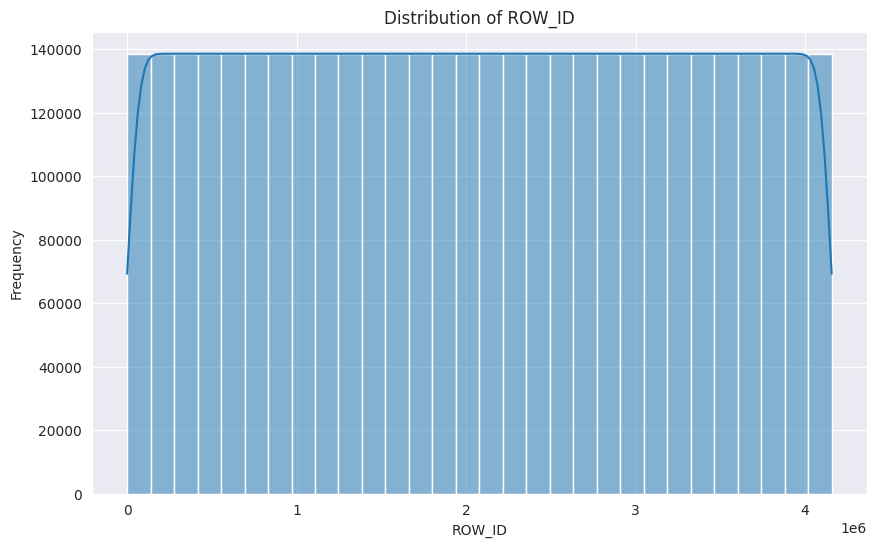

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(prescriptions['ROW_ID'], kde=True, bins=30)
plt.title('Distribution of ROW_ID')
plt.xlabel('ROW_ID')
plt.ylabel('Frequency')
plt.show()


In [9]:
prescriptions.to_csv('prescriptions_cleaned.csv', index=False)


In [10]:
!pip install sdv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set environment variables for multiprocessing
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Load the cleaned dataset
prescriptions_cleaned = pd.read_csv('prescriptions_cleaned.csv')


In [ ]:
# Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(prescriptions_cleaned)

# Initialize and fit the synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=300)
synthesizer.fit(prescriptions_cleaned)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
STARTDATE              11
ENDDATE                11
DRUG_TYPE              3
DRUG                   4525
DRUG_NAME_POE          4037
DRUG_NAME_GENERIC      2864
FORMULARY_DRUG_CD      3268
GSN                    4686
NDC                    11
PROD_STRENGTH          4001
DOSE_VAL_RX            2606
DOSE_UNIT_RX           105
FORM_VAL_DISP          3074
FORM_UNIT_DISP         85
ROUTE                  79
DRUG_TYPE_ENC          3
DRUG_ENC               11
DRUG_NAME_GENERIC_ENC  11
ROUTE_ENC              11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


In [ ]:
# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_prescriptions.csv", index=False)
synthetic_data.head()


In [ ]:
# Compare distributions of a categorical column
column = 'DRUG_TYPE_ENC'

plt.figure(figsize=(10,5))
sns.histplot(prescriptions_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [ ]:
# Create a binary target based on DOSE_VAL_RX
prescriptions_cleaned['TARGET'] = (prescriptions_cleaned['DOSE_VAL_RX'] > 1).astype(int)
synthetic_data['TARGET'] = (synthetic_data['DOSE_VAL_RX'] > 1).astype(int)

features = ['DRUG_TYPE_ENC', 'ROUTE_ENC']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = prescriptions_cleaned[features]
y_real = prescriptions_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"Model accuracy on real data:     {real_acc:.2f}")
print(f"Model accuracy on synthetic data:{syn_acc:.2f}")


In [ ]:

#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=10
)

# Fit the VAE synthesizer
vae_synthesizer.fit(prescriptions_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_prescriptions_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_prescriptions_vae.csv')

# Preprocessing: convert categorical columns to numeric codes
features = ['DRUG_TYPE_ENC', 'ROUTE_ENC']
target = 'TARGET'

# Make sure all datasets are prepared
for col in features:
    prescriptions_cleaned[col] = prescriptions_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = prescriptions_cleaned[features]
y_real = prescriptions_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()